In [1]:
# =====================================================
# Phase 2 Part 2 - BPE Evaluation Notebook
# =====================================================


import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

In [2]:
# ----------------------------
# 1. Setup
# ----------------------------

# Ensure we can import project modules
sys.path.append(os.path.abspath(".."))

# Load dataset with professional tokens
df = pd.read_csv("../data/python_docstrings.csv")

# Load trained BPE models
with open("../bpe/bpe_code.pkl", "rb") as f:
    bpe_code = pickle.load(f)

with open("../bpe/bpe_doc.pkl", "rb") as f:
    bpe_doc = pickle.load(f)

print("Dataset size:", df.shape)

Dataset size: (455243, 13)


In [ ]:
# ----------------------------
# 2. Use a subset for evaluation (speed)
# ----------------------------

sample_df = df.sample(50, random_state=42)  
print("Evaluation subset size:", sample_df.shape)

Evaluation subset size: (50, 13)


In [4]:
# ----------------------------
# 3. Define evaluation metrics
# ----------------------------

def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2) if set1 | set2 else 0


def evaluate_tokenizer(bpe, texts, reference_tokens):
    jaccard_scores = []
    oov_counts = []
    compression_ratios = []
    
    for text, ref in zip(texts, reference_tokens):
        encoded = bpe.encode(text)
        encoded_set = set(encoded)
        ref_set = set(ref)
        
        # Jaccard similarity
        js = jaccard_similarity(encoded_set, ref_set)
        jaccard_scores.append(js)
        
        # OOV count
        oov = len(ref_set - encoded_set)
        oov_counts.append(oov)
        
        # Compression ratio
        compression = len(text) / len(encoded) if len(encoded) > 0 else 0
        compression_ratios.append(compression)
    
    return {
        "avg_jaccard": np.mean(jaccard_scores),
        "avg_oov": np.mean(oov_counts),
        "avg_compression": np.mean(compression_ratios),
        "details": {
            "jaccard_scores": jaccard_scores,
            "oov_counts": oov_counts,
            "compression_ratios": compression_ratios
        }
    }

In [5]:
# ----------------------------
# 4. Run Evaluation
# ----------------------------

results_code = evaluate_tokenizer(
    bpe_code,
    sample_df['code'].astype(str).tolist(),
    sample_df['code_tokens'].tolist()
)


results_doc = evaluate_tokenizer(
    bpe_doc,
    sample_df['docstring'].astype(str).tolist(),
    sample_df['docstring_tokens'].tolist()
)


print("Code Tokenizer Evaluation:", results_code)
print("Docstring Tokenizer Evaluation:", results_doc)

Code Tokenizer Evaluation: {'avg_jaccard': np.float64(0.38877102483812387), 'avg_oov': np.float64(4.92), 'avg_compression': np.float64(1.3237500211036357), 'details': {'jaccard_scores': [0.3026315789473684, 0.38848920863309355, 0.4298245614035088, 0.46601941747572817, 0.2826086956521739, 0.36496350364963503, 0.4132231404958678, 0.379746835443038, 0.4642857142857143, 0.3979591836734694, 0.3492063492063492, 0.2692307692307692, 0.3394495412844037, 0.34782608695652173, 0.37593984962406013, 0.3944954128440367, 0.4507042253521127, 0.30303030303030304, 0.45, 0.5193798449612403, 0.35344827586206895, 0.46153846153846156, 0.42045454545454547, 0.4857142857142857, 0.4186046511627907, 0.35135135135135137, 0.3137254901960784, 0.36363636363636365, 0.4111111111111111, 0.375, 0.3233082706766917, 0.31007751937984496, 0.4605263157894737, 0.45161290322580644, 0.345679012345679, 0.4067796610169492, 0.3431372549019608, 0.39215686274509803, 0.34782608695652173, 0.2755905511811024, 0.38028169014084506, 0.4375

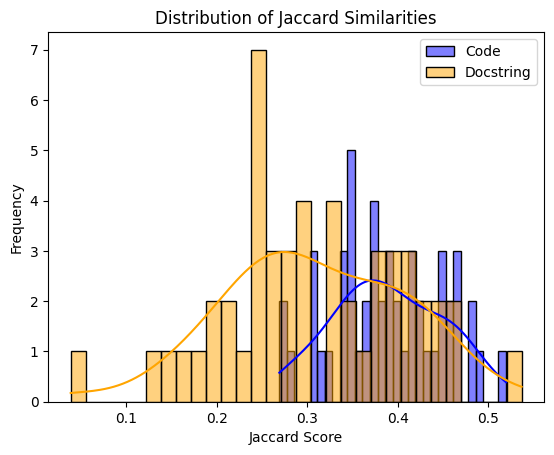

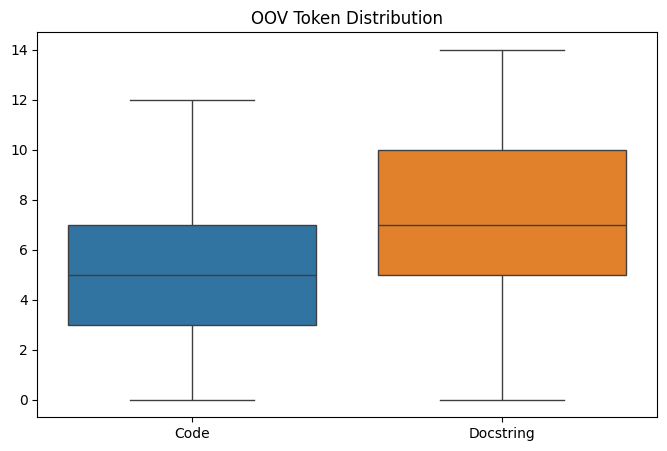

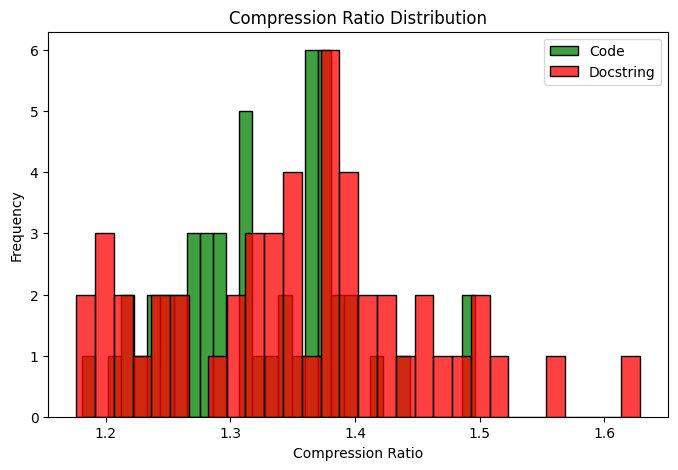

In [6]:
# ----------------------------
# 5. Visualizations
# ----------------------------

# Jaccard distribution
sns.histplot(results_code["details"]["jaccard_scores"], bins=30, kde=True, color="blue", label="Code")
sns.histplot(results_doc["details"]["jaccard_scores"], bins=30, kde=True, color="orange", label="Docstring")
plt.title("Distribution of Jaccard Similarities")
plt.xlabel("Jaccard Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# OOV distribution
plt.figure(figsize=(8,5))
sns.boxplot(data=[results_code["details"]["oov_counts"], results_doc["details"]["oov_counts"]])
plt.xticks([0,1], ["Code", "Docstring"])
plt.title("OOV Token Distribution")
plt.show()


# Compression ratio
plt.figure(figsize=(8,5))
sns.histplot(results_code["details"]["compression_ratios"], bins=30, color="green", label="Code")
sns.histplot(results_doc["details"]["compression_ratios"], bins=30, color="red", label="Docstring")
plt.title("Compression Ratio Distribution")
plt.xlabel("Compression Ratio")
plt.ylabel("Frequency")
plt.legend()
plt.show()